In [ ]:
import mo_gymnasium as mo_gym
import numpy as np
from collections import Counter
from scipy.spatial.distance import cdist
from scipy.linalg import LinAlgError
from itertools import combinations
import matplotlib.pyplot as plt

In [ ]:
# entorno
entorno = mo_gym.make('mo-lunar-lander-v3')

def vector_a_politica(vector_pesos, dim_obs=8, dim_act=4):
    return vector_pesos.reshape((dim_act, dim_obs))

def seleccionar_accion(politica, obs):
    logits = politica @ obs
    return np.argmax(logits)

In [ ]:
# evaluación de política
def evaluar_politica(politica, entorno, episodios=5, semilla=None, retornar_todas=False):
    if semilla is not None:
        np.random.seed(semilla)

    recompensas = []
    for _ in range(episodios):
        obs, _ = entorno.reset()
        total = np.zeros(4, dtype=np.float32)
        terminado, truncado = False, False
        while not (terminado or truncado):
            accion = seleccionar_accion(politica, obs)
            obs, r_vec, terminado, truncado, _ = entorno.step(accion)
            total += r_vec
        recompensas.append(total)

    recompensas = np.array(recompensas)
    return recompensas if retornar_todas else np.mean(recompensas, axis=0)

In [ ]:
# población y evaluación
def inicializar_poblacion(tamano, dimensiones):
    return np.random.uniform(-1, 1, size=(tamano, dimensiones))

def evaluar_poblacion(poblacion, entorno):
    recompensas = []
    for individuo in poblacion:
        politica = vector_a_politica(individuo)
        recompensa = evaluar_politica(politica, entorno)
        recompensas.append(recompensa)
    return np.array(recompensas)

In [ ]:
# ordenamiento de puntos no dominados
def ordenar_no_dominadas(matriz_objetivos):
    num_individuos, num_objetivos = matriz_objetivos.shape
    dominado_por = np.zeros(num_individuos, dtype=int)
    domina_a = [[] for _ in range(num_individuos)]
    frentes = {0: []}
    rango = np.zeros(num_individuos, dtype=int)

    for i in range(num_individuos):
        for j in range(num_individuos):
            if i != j:
                mejor, igual, peor = 0, 0, 0
                for k in range(num_objetivos):
                    if matriz_objetivos[i, k] < matriz_objetivos[j, k]: mejor += 1
                    elif matriz_objetivos[i, k] == matriz_objetivos[j, k]: igual += 1
                    else: peor += 1
                if mejor == 0 and igual != num_objetivos: dominado_por[i] += 1
                elif peor == 0 and igual != num_objetivos: domina_a[i].append(j)
        if dominado_por[i] == 0:
            frentes[0].append(i)
            rango[i] = 0

    i = 0
    while frentes[i]:
        siguiente_frente = []
        for p in frentes[i]:
            for q in domina_a[p]:
                dominado_por[q] -= 1
                if dominado_por[q] == 0:
                    rango[q] = i + 1
                    siguiente_frente.append(q)
        i += 1
        frentes[i] = siguiente_frente

    frentes.pop(i)
    return frentes, rango

In [ ]:
# funciones 
def factorial(n):
    return 1 if n <= 1 else n * factorial(n - 1)

def combinacion(n, m):
    if m == 0 or m == n: return 1
    elif m > n: return 0
    return factorial(n) // (factorial(m) * factorial(n - m))

In [ ]:
# puntos de referencia
def generar_puntos_referencia(tamano_poblacion, num_obj):
    h1 = 0
    while combinacion(h1 + num_obj, num_obj - 1) <= tamano_poblacion:
        h1 += 1
    puntos = np.array(list(combinations(np.arange(1, h1 + num_obj), num_obj - 1))) - np.arange(num_obj - 1) - 1
    puntos = (np.concatenate((puntos, np.zeros((puntos.shape[0], 1)) + h1), axis=1) -
              np.concatenate((np.zeros((puntos.shape[0], 1)), puntos), axis=1)) / h1

    if h1 < num_obj:
        h2 = 0
        while combinacion(h1 + num_obj - 1, num_obj - 1) + combinacion(h2 + num_obj, num_obj - 1) <= tamano_poblacion:
            h2 += 1
        if h2 > 0:
            puntos_extra = np.array(list(combinations(np.arange(1, h2 + num_obj), num_obj - 1))) - np.arange(num_obj - 1) - 1
            puntos_extra = (np.concatenate((puntos_extra, np.zeros((puntos_extra.shape[0], 1)) + h2), axis=1) -
                            np.concatenate((np.zeros((puntos_extra.shape[0], 1)), puntos_extra), axis=1)) / h2
            puntos_extra = puntos_extra / 2 + 1 / (2 * num_obj)
            puntos = np.concatenate((puntos, puntos_extra), axis=0)
    return puntos

In [ ]:
def evaluar_politicas_scalarizadas(poblacion, recompensas, pesos_list, entorno_original, episodios=5):
    print("\nEvaluación con diferentes configuraciones de pesos:")
    for i, w in enumerate(pesos_list):
        entorno_scalar = mo_gym.wrappers.LinearReward(entorno_original, weight=w)
        print(f"\n👉 Configuración de pesos {i+1}: {w}")
        for j in range(3):  # Tomamos 3 políticas representativas del frente
            politica = vector_a_politica(poblacion[j])
            recompensa_scalar = 0
            for _ in range(episodios):
                obs, _ = entorno_scalar.reset()
                total = 0
                done = False
                while not done:
                    accion = seleccionar_accion(politica, obs)
                    obs, reward, terminated, truncated, _ = entorno_scalar.step(accion)
                    done = terminated or truncated
                    total += reward
                recompensa_scalar += total
            recompensa_prom = recompensa_scalar / episodios
            print(f"  Política {j+1}: Recompensa escalar promedio = {recompensa_prom:.2f}")

In [ ]:
def normalizar_recompensas(recompensas, indices_frente0):
    ideal = recompensas.min(axis=0)
    if len(indices_frente0) == 0:
        nadir = recompensas.max(axis=0)
    else:
        nadir = recompensas[indices_frente0].max(axis=0)
    return (recompensas - ideal) / (nadir - ideal + 1e-12)

In [ ]:
# selección del ambiente
def seleccion_ambiental(poblacion, recompensas, referencias, tamano_poblacion):
    frentes, rangos = ordenar_no_dominadas(recompensas)
    num_obj = recompensas.shape[1]

    seleccionados = np.full(poblacion.shape[0], False)
    frente_actual = 0
    while np.sum(seleccionados) + len(frentes[frente_actual]) <= tamano_poblacion:
        seleccionados[frentes[frente_actual]] = True
        frente_actual += 1

    faltantes = tamano_poblacion - np.sum(seleccionados)

    recompensas_normalizadas = normalizar_recompensas(
        np.vstack([recompensas[seleccionados], recompensas[frentes[frente_actual]]]),
        list(range(np.sum(seleccionados)))
    )

    distancias = np.sqrt((recompensas_normalizadas**2).sum(axis=1)).reshape(-1, 1)
    proyecciones = 1 - cdist(recompensas_normalizadas, referencias, metric="cosine")
    distancias_perpendiculares = distancias * np.sqrt(1 - proyecciones**2)
    asociaciones = np.argmin(distancias_perpendiculares, axis=1)

    conteos = Counter(asociaciones[:np.sum(seleccionados)])
    conteo_por_nicho = np.zeros(len(referencias))
    for k, v in conteos.items():
        conteo_por_nicho[k] = v

    seleccion_final = np.full(len(frentes[frente_actual]), False)
    referencias_activas = np.full(len(referencias), True)
    seleccionados_extra = []

    while np.sum(seleccion_final) < faltantes:
        disponibles = np.where(referencias_activas)[0]
        min_nicho = np.min(conteo_por_nicho[disponibles])
        candidatos_nicho = disponibles[conteo_por_nicho[disponibles] == min_nicho]
        nicho_seleccionado = np.random.choice(candidatos_nicho)

        candidatos_sol = np.where((asociaciones[np.sum(seleccionados):] == nicho_seleccionado) & (~seleccion_final))[0]
        if len(candidatos_sol) > 0:
            if conteo_por_nicho[nicho_seleccionado] == 0:
                mejor = candidatos_sol[np.argmin(distancias_perpendiculares[np.sum(seleccionados) + candidatos_sol, nicho_seleccionado])]
            else:
                mejor = np.random.choice(candidatos_sol)
            seleccion_final[mejor] = True
            seleccionados_extra.append(frentes[frente_actual][mejor])
            conteo_por_nicho[nicho_seleccionado] += 1
        else:
            referencias_activas[nicho_seleccionado] = False

    indices_finales = list(np.where(seleccionados)[0]) + seleccionados_extra
    nueva_poblacion = poblacion[indices_finales]
    nuevas_recompensas = recompensas[indices_finales]
    nuevos_rangos = np.array(rangos)[indices_finales]

    return nueva_poblacion, nuevas_recompensas, nuevos_rangos

In [ ]:
# torneo binario para selección de cruza
def seleccion_torneo(poblacion, prob_cruce, rangos, k=2):
    tamano_poblacion, num_variables = poblacion.shape
    num_cruzas = int(tamano_poblacion * prob_cruce)
    if num_cruzas % 2 != 0:
        num_cruzas += 1
    conjunto_cruza = np.zeros((num_cruzas, num_variables))
    for i in range(num_cruzas):
        ind1, ind2 = np.random.choice(tamano_poblacion, k, replace=False)
        if rangos[ind1] <= rangos[ind2]:
            conjunto_cruza[i] = poblacion[ind1]
        else:
            conjunto_cruza[i] = poblacion[ind2]
    return conjunto_cruza

In [ ]:
# cruza SBX
def operador_cruce(conjunto_cruza, limites_inferiores, limites_superiores, prob_cruce, eta_distribucion):
    num_hijos, num_variables = conjunto_cruza.shape
    mitad = int(num_hijos / 2)
    padres1 = conjunto_cruza[:mitad]
    padres2 = conjunto_cruza[mitad:]
    beta = np.zeros((mitad, num_variables))
    mu = np.random.random((mitad, num_variables))
    condicion1 = mu <= 0.5
    condicion2 = ~condicion1
    beta[condicion1] = (2 * mu[condicion1]) ** (1 / (eta_distribucion + 1))
    beta[condicion2] = (2 - 2 * mu[condicion2]) ** (-1 / (eta_distribucion + 1))
    beta = beta * (-1) ** np.random.randint(0, 2, (mitad, num_variables))
    beta[np.random.random((mitad, num_variables)) < 0.5] = 1
    beta[np.tile(np.random.random((mitad, 1)) > prob_cruce, (1, num_variables))] = 1
    hijos1 = (padres1 + padres2) / 2 + beta * (padres1 - padres2) / 2
    hijos2 = (padres1 + padres2) / 2 - beta * (padres1 - padres2) / 2
    hijos = np.concatenate((hijos1, hijos2), axis=0)
    hijos = np.minimum(hijos, np.tile(limites_superiores, (num_hijos, 1)))
    hijos = np.maximum(hijos, np.tile(limites_inferiores, (num_hijos, 1)))
    return hijos

In [ ]:
# mutación polinomial
def operador_mutacion(poblacion, limites_inferiores, limites_superiores, prob_mutacion, eta_mutacion):
    tamano_poblacion, num_variables = poblacion.shape
    limites_inferiores = np.tile(limites_inferiores, (tamano_poblacion, 1))
    limites_superiores = np.tile(limites_superiores, (tamano_poblacion, 1))
    mascara_mutacion = np.random.random((tamano_poblacion, num_variables)) < prob_mutacion / num_variables
    valores_aleatorios = np.random.random((tamano_poblacion, num_variables))
    delta_inferior = (poblacion - limites_inferiores) / (limites_superiores - limites_inferiores)
    delta_superior = (limites_superiores - poblacion) / (limites_superiores - limites_inferiores)
    condicion_baja = np.logical_and(mascara_mutacion, valores_aleatorios <= 0.5)
    poblacion[condicion_baja] += (limites_superiores[condicion_baja] - limites_inferiores[condicion_baja]) * \
        ((2 * valores_aleatorios[condicion_baja] + (1 - 2 * valores_aleatorios[condicion_baja]) *
          (1 - delta_inferior[condicion_baja]) ** (eta_mutacion + 1)) ** (1 / (eta_mutacion + 1)) - 1)
    condicion_alta = np.logical_and(mascara_mutacion, valores_aleatorios > 0.5)
    poblacion[condicion_alta] += (limites_superiores[condicion_alta] - limites_inferiores[condicion_alta]) * \
        (1 - (2 * (1 - valores_aleatorios[condicion_alta]) + 2 * (valores_aleatorios[condicion_alta] - 0.5) *
              (1 - delta_superior[condicion_alta]) ** (eta_mutacion + 1)) ** (1 / (eta_mutacion + 1)))
    poblacion = np.minimum(poblacion, limites_superiores)
    poblacion = np.maximum(poblacion, limites_inferiores)
    return poblacion

Generación 1/1000
Generación 2/1000
Generación 3/1000
Generación 4/1000
Generación 5/1000
Generación 6/1000
Generación 7/1000
Generación 8/1000
Generación 9/1000
Generación 10/1000
Generación 11/1000
Generación 12/1000
Generación 13/1000
Generación 14/1000
Generación 15/1000
Generación 16/1000
Generación 17/1000
Generación 18/1000
Generación 19/1000
Generación 20/1000
Generación 21/1000
Generación 22/1000
Generación 23/1000
Generación 24/1000
Generación 25/1000
Generación 26/1000
Generación 27/1000
Generación 28/1000
Generación 29/1000
Generación 30/1000
Generación 31/1000
Generación 32/1000
Generación 33/1000
Generación 34/1000
Generación 35/1000
Generación 36/1000
Generación 37/1000
Generación 38/1000
Generación 39/1000
Generación 40/1000
Generación 41/1000
Generación 42/1000
Generación 43/1000
Generación 44/1000
Generación 45/1000
Generación 46/1000
Generación 47/1000
Generación 48/1000
Generación 49/1000
Generación 50/1000
Generación 51/1000
Generación 52/1000
Generación 53/1000
Ge

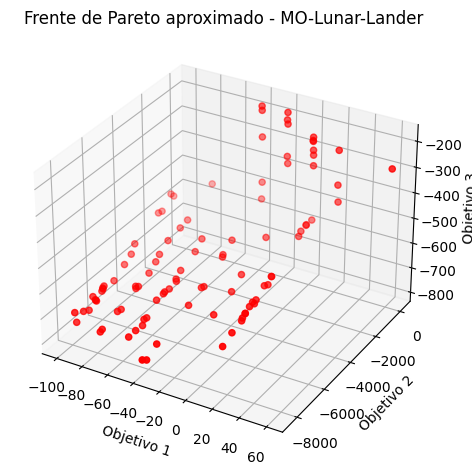

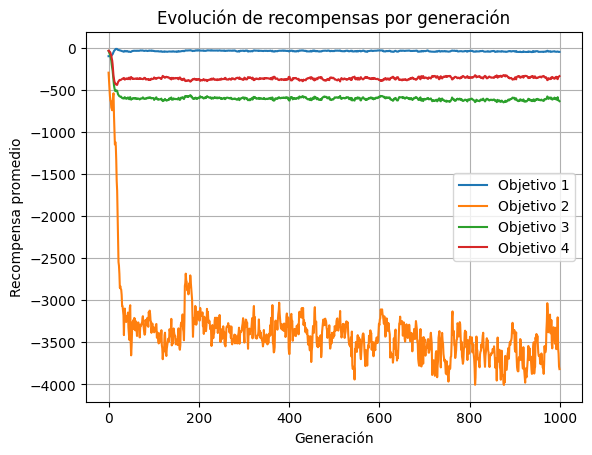

In [ ]:
# 13. Entrenamiento principal de NSGA-III

def entrenar_nsga3_mo_lunar(
    tamano_poblacion=100,
    num_generaciones=1000,
    prob_cruce=1.0,
    prob_mutacion=1.0,
    eta_cruce=30,
    eta_mutacion=20
):
    dimensiones = 32
    num_objetivos = 4
    limites_inf = np.full(dimensiones, -1.0)
    limites_sup = np.full(dimensiones, 1.0)

    poblacion = inicializar_poblacion(tamano_poblacion, dimensiones)
    recompensas = evaluar_poblacion(poblacion, entorno)
    referencias = generar_puntos_referencia(tamano_poblacion, num_objetivos)

    recompensas_generacion = []

    for gen in range(num_generaciones):
        if (gen + 1) % 1 == 0:
            print(f"Generación {gen + 1}/{num_generaciones}")

        frentes, rangos = ordenar_no_dominadas(recompensas)
        recompensas_generacion.append(np.mean(recompensas, axis=0))

        padres = seleccion_torneo(poblacion, prob_cruce, rangos)
        hijos = operador_cruce(padres, limites_inf, limites_sup, prob_cruce, eta_cruce)
        hijos = operador_mutacion(hijos, limites_inf, limites_sup, prob_mutacion, eta_mutacion)
        recompensas_hijos = evaluar_poblacion(hijos, entorno)

        poblacion_combinada = np.vstack([poblacion, hijos])
        recompensas_combinadas = np.vstack([recompensas, recompensas_hijos])
        poblacion, recompensas, _ = seleccion_ambiental(poblacion_combinada, recompensas_combinadas, referencias, tamano_poblacion)

    frente_pareto = recompensas
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(frente_pareto[:, 0], frente_pareto[:, 1], frente_pareto[:, 2], color='red')
    ax.set_xlabel('Objetivo 1')
    ax.set_ylabel('Objetivo 2')
    ax.set_zlabel('Objetivo 3')
    ax.set_title('Frente de Pareto aproximado - MO-Lunar-Lander')
    plt.tight_layout()
    plt.show()

    recompensas_generacion = np.array(recompensas_generacion)
    for i in range(recompensas_generacion.shape[1]):
        plt.plot(recompensas_generacion[:, i], label=f'Objetivo {i+1}')
    plt.xlabel('Generación')
    plt.ylabel('Recompensa promedio')
    plt.title('Evolución de recompensas por generación')
    plt.legend()
    plt.grid(True)
    plt.show()

    # # Evaluación escalarizada final con distintos pesos
    # pesos_list = [
    #     np.array([1.0, 0.0, 0.0, 0.0]),
    #     np.array([0.0, 1.0, 0.0, 0.0]),
    #     np.array([0.25, 0.25, 0.25, 0.25]),
    #     np.array([0.4, 0.3, 0.2, 0.1])
    # ]
    # evaluar_politicas_scalarizadas(poblacion, recompensas, pesos_list, entorno)

if __name__ == "__main__":
    entrenar_nsga3_mo_lunar()